In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
import tensorflow as tf

2024-11-25 21:10:45.268144: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 21:10:45.273105: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 21:10:45.292052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732549245.323921  215766 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732549245.333227  215766 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 21:10:45.364821: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

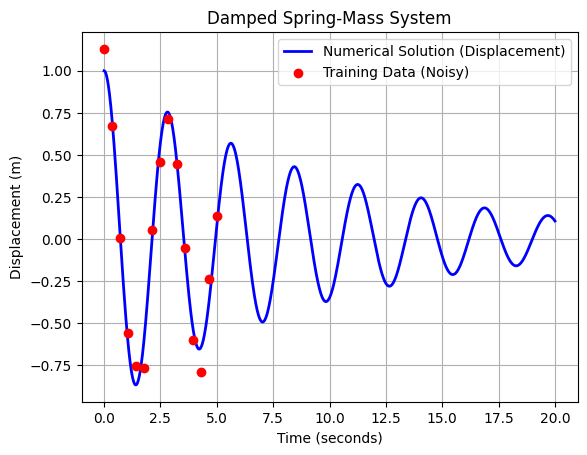

In [2]:

# Constants for the damped spring-mass system
m = 1.0  # Mass (kg)
c = 0.2  # Damping coefficient (kg/s)
k = 5.0  # Spring constant (N/m)
x0 = 1.0  # Initial displacement (m)
v0 = 0.0  # Initial velocity (m/s)
time_end = 20  # End time for simulation (seconds)

# Define the system of equations for the damped spring-mass system
def damped_spring_mass(t, y):
    x, v = y
    dxdt = v
    dvdt = -(c / m) * v - (k / m) * x
    return [dxdt, dvdt]

# Time vector for the full plot
time = np.linspace(0, time_end, 1000)  # 1000 time points for smooth curve

# Solve the system numerically
solution = solve_ivp(
    damped_spring_mass,
    [0, time_end],
    [x0, v0],
    t_eval=time,
    method='RK45'
)

# Extract displacement (x) over time
x = solution.y[0]

# Sample 15 data points from the plot (evenly spaced in time, up to 5 seconds)
sample_times = np.linspace(0, 5, 15)  # Sample points from 0 to 5 seconds
sample_displacements = np.interp(sample_times, time, x)

# Add noise to the sampled data
noise = np.random.normal(0, 0.1, size=sample_displacements.shape)  # Noise with std dev of 0.1
noisy_sample_displacements = sample_displacements + noise

# Plot the displacement vs time curve (until 20 seconds)
plt.plot(time, x, label='Numerical Solution (Displacement)', color='blue', lw=2)

# Plot the noisy training data points (until 5 seconds)
plt.scatter(sample_times, noisy_sample_displacements, color='red', label='Training Data (Noisy)', zorder=5)

# Labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (m)')
plt.title('Damped Spring-Mass System')
plt.legend()

# Show plot
plt.grid(True)
plt.show()


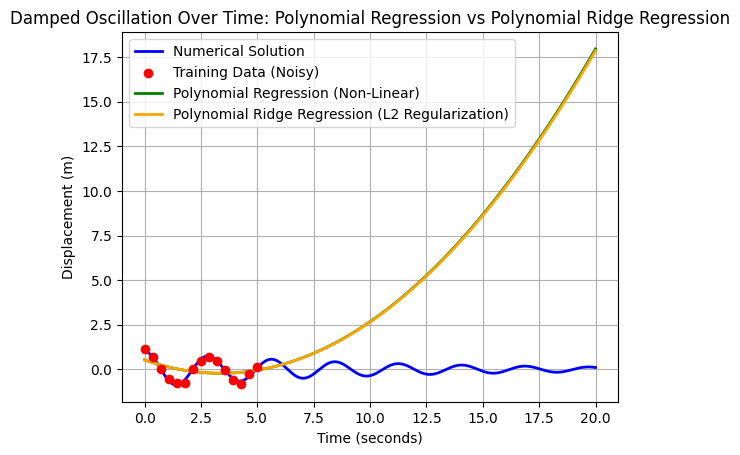

In [3]:
# Reshape the data for the models
X_train = sample_times.reshape(-1, 1)  # Reshape for sklearn input
y_train = noisy_sample_displacements  # Target temperatures

# 1. Polynomial Regression (Non-Linear Regression)
poly = PolynomialFeatures(degree=2)  # Degree of the polynomial
X_poly = poly.fit_transform(X_train)  # Transform the input to higher dimensions (polynomial features)

# Train a Linear Regression on the polynomial features
poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)

# Predict using the polynomial model for the entire time range (0-1000 seconds)
X_poly_full = poly.transform(time.reshape(-1, 1))  # Transform time values to polynomial features
predicted_temperatures_poly = poly_model.predict(X_poly_full)

# 2. Polynomial Ridge Regression (Non-Linear Regression with L2 Regularization)
ridge_poly_model = Ridge(alpha=0.01)  # alpha controls the strength of regularization
ridge_poly_model.fit(X_poly, y_train)

# Predict using the polynomial Ridge regression model
predicted_temperatures_ridge_poly = ridge_poly_model.predict(X_poly_full)

# Plot the equation-based curve and the model predictions
plt.plot(time, x, label="Numerical Solution", color='blue', lw=2)
plt.scatter(sample_times, noisy_sample_displacements, color='red', label="Training Data (Noisy)", zorder=5)
plt.plot(time, predicted_temperatures_poly, label="Polynomial Regression (Non-Linear)", color='green', lw=2)
plt.plot(time, predicted_temperatures_ridge_poly, label="Polynomial Ridge Regression (L2 Regularization)", color='orange', lw=2)

# Labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (m)')
plt.title("Damped Oscillation Over Time: Polynomial Regression vs Polynomial Ridge Regression")
plt.legend()

# Show plot
plt.grid(True)
plt.show()


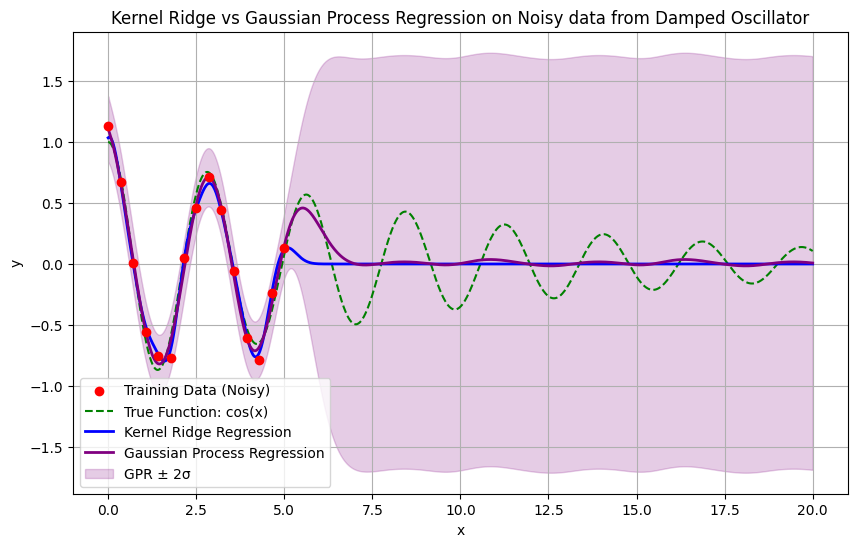

In [4]:
# Test data (fine-grained grid for smooth plotting)
Y_test = x.reshape(-1,1)
X_test = time.reshape(-1,1)

# Kernel Ridge Regression with Gaussian kernel (RBF)
krr = KernelRidge(kernel="rbf", alpha=0.1, gamma=5)  # gamma controls kernel width
krr.fit(X_train, y_train)
y_krr = krr.predict(X_test)

# Gaussian Process Regression with periodic kernel + RBF + white noise
kernel = (
    1.0 * ExpSineSquared(length_scale=1.0, periodicity=2 * np.pi)
    + 0.1 * RBF(length_scale=1.0)
    + 0.1 * WhiteKernel(noise_level=0.1)
)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train, y_train)
y_gpr, y_std = gpr.predict(X_test, return_std=True)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot training data
plt.scatter(X_train, y_train, color="red", label="Training Data (Noisy)", zorder=5)

# Plot true function
plt.plot(X_test, Y_test, color="green", label="True Function: cos(x)", linestyle="--")

# Plot Kernel Ridge Regression result
plt.plot(X_test, y_krr, color="blue", label="Kernel Ridge Regression", lw=2)

# Plot Gaussian Process Regression result
plt.plot(X_test, y_gpr, color="purple", label="Gaussian Process Regression", lw=2)
plt.fill_between(
    X_test.ravel(),
    y_gpr - 2 * y_std,
    y_gpr + 2 * y_std,
    color="purple",
    alpha=0.2,
    label="GPR ± 2σ",
)

# Labels and legend
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Ridge vs Gaussian Process Regression on Noisy data from Damped Oscillator")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
X_test.shape

(1000, 1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


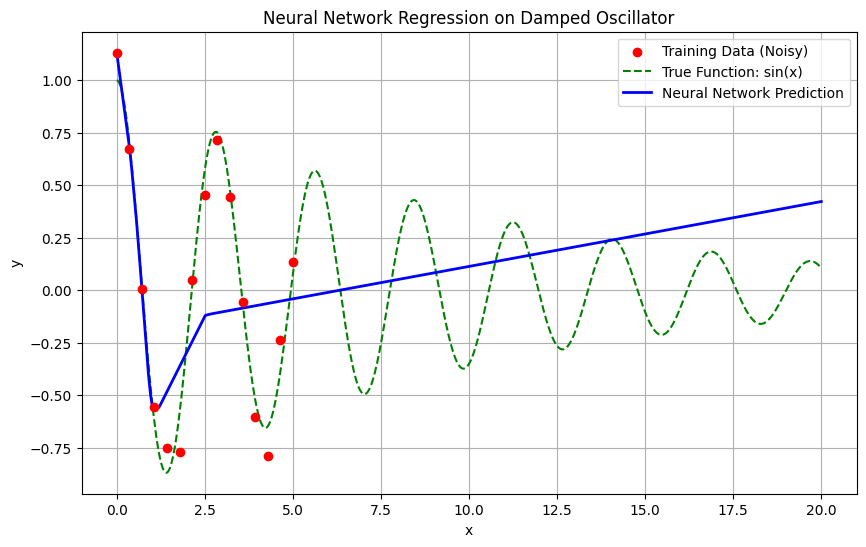

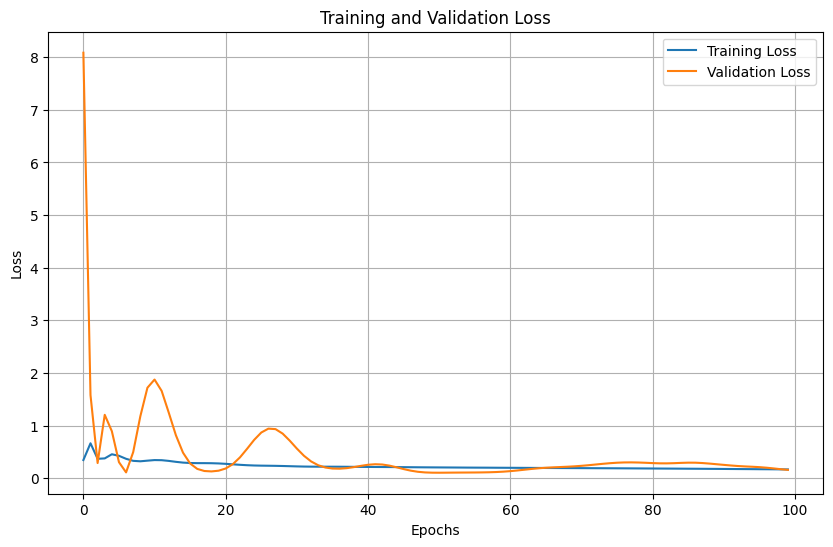

In [7]:
# Neural Network Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Single output
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mse',  # Mean Squared Error
              metrics=['mae'])  # Mean Absolute Error


X_test_new , X_val, y_test_new, y_val = train_test_split(X_test, Y_test, test_size=0.02, random_state=42)


# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=16, verbose=0)

y_test_pred = model.predict(X_test)
# Plotting the results
plt.figure(figsize=(10, 6))

# Plot training data
plt.scatter(X_train, y_train, color='red', label='Training Data (Noisy)', zorder=5)

# Plot true function
plt.plot(X_test, Y_test , color='green', label='True Function: sin(x)', linestyle='--')

# Plot Neural Network prediction
plt.plot(X_test, y_test_pred, color='blue', label='Neural Network Prediction', lw=2)

# Labels and legend
plt.xlabel("x")
plt.ylabel("y")
plt.title("Neural Network Regression on Damped Oscillator")
plt.legend()
plt.grid(True)
plt.show()

# Plot loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
